# Implementing GRAPE Algorithm
## First Order
### GRAPE calculation of control fields for cnot implementation
Ref: https://nbviewer.org/github/qutip/qutip-notebooks/blob/master/examples/control-grape-cnot.ipynb

In [42]:
import matplotlib.pyplot as plt
import time
import numpy as np
from qutip import *
from qutip.control import *
from qutip_qip.operations import cnot
from qutip import Options, QobjEvo

In [43]:
T = 2 * np.pi # Period
times = np.linspace(0, T, 500)

In [44]:
# Define the Operators
U = cnot()
R = 500
H_ops = [
    tensor(sigmax(), qeye(2)),
    tensor(sigmay(), qeye(2)),
    tensor(sigmaz(), qeye(2)),
    tensor(qeye(2), sigmax()),
    tensor(qeye(2), sigmay()),
    tensor(qeye(2), sigmaz()),
    tensor(sigmax(), sigmax()),
    tensor(sigmay(), sigmay()),
    tensor(sigmaz(), sigmaz())
]

H_labels = [
    r'$u_{1x}$', r'$u_{1y}$', r'$u_{1z}$',
    r'$u_{2x}$', r'$u_{1y}$', r'$u_{2z}$',
    r'$u_{xx}$', r'$u_{yy}$', r'$u_{zz}$',
    ]

In [45]:
# System Hamiltonian
H0 = 0 * np.pi * (tensor(sigmax(), qeye(2)) + tensor(qeye(2), sigmax()))

c_ops = []

#### GRAPE

In [46]:
from qutip.control.grape import plot_grape_control_fields, _overlap, grape_unitary #in this version cy_grape... was became grape...
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [47]:
# initialize control pulses with random values
u0 = np.array([np.random.rand(len(times)) * 2 * np.pi * 0.05 for _ in range(len(H_ops))])
# Smooth the initial controls
u0 =[np.convolve(np.ones(10)/10, u0[idx, :], mode='same') for idx in range(len(H_ops))]

# u_limits is limitaion of the control pulse for experimental reasons
u_limits = None #[0, 1 * 2 * pi]

# Regularization parameter for the control fields
alpha = None

In [48]:
result = grape_unitary(U, H0, H_ops, R, times, u_start=u0, u_limits=u_limits,
                          eps=2*np.pi*0.8, alpha=alpha, phase_sensitive=False,
                          progress_bar=TextProgressBar(R))

10.0%. Run time:  27.90s. Est. time left: 00:00:04:11
20.0%. Run time:  56.39s. Est. time left: 00:00:03:45
30.0%. Run time:  84.98s. Est. time left: 00:00:03:18
40.0%. Run time: 113.20s. Est. time left: 00:00:02:49
50.0%. Run time: 141.23s. Est. time left: 00:00:02:21
60.0%. Run time: 169.50s. Est. time left: 00:00:01:53
70.0%. Run time: 197.08s. Est. time left: 00:00:01:24
80.0%. Run time: 225.43s. Est. time left: 00:00:00:56
90.0%. Run time: 254.56s. Est. time left: 00:00:00:28
Total run time: 281.19s


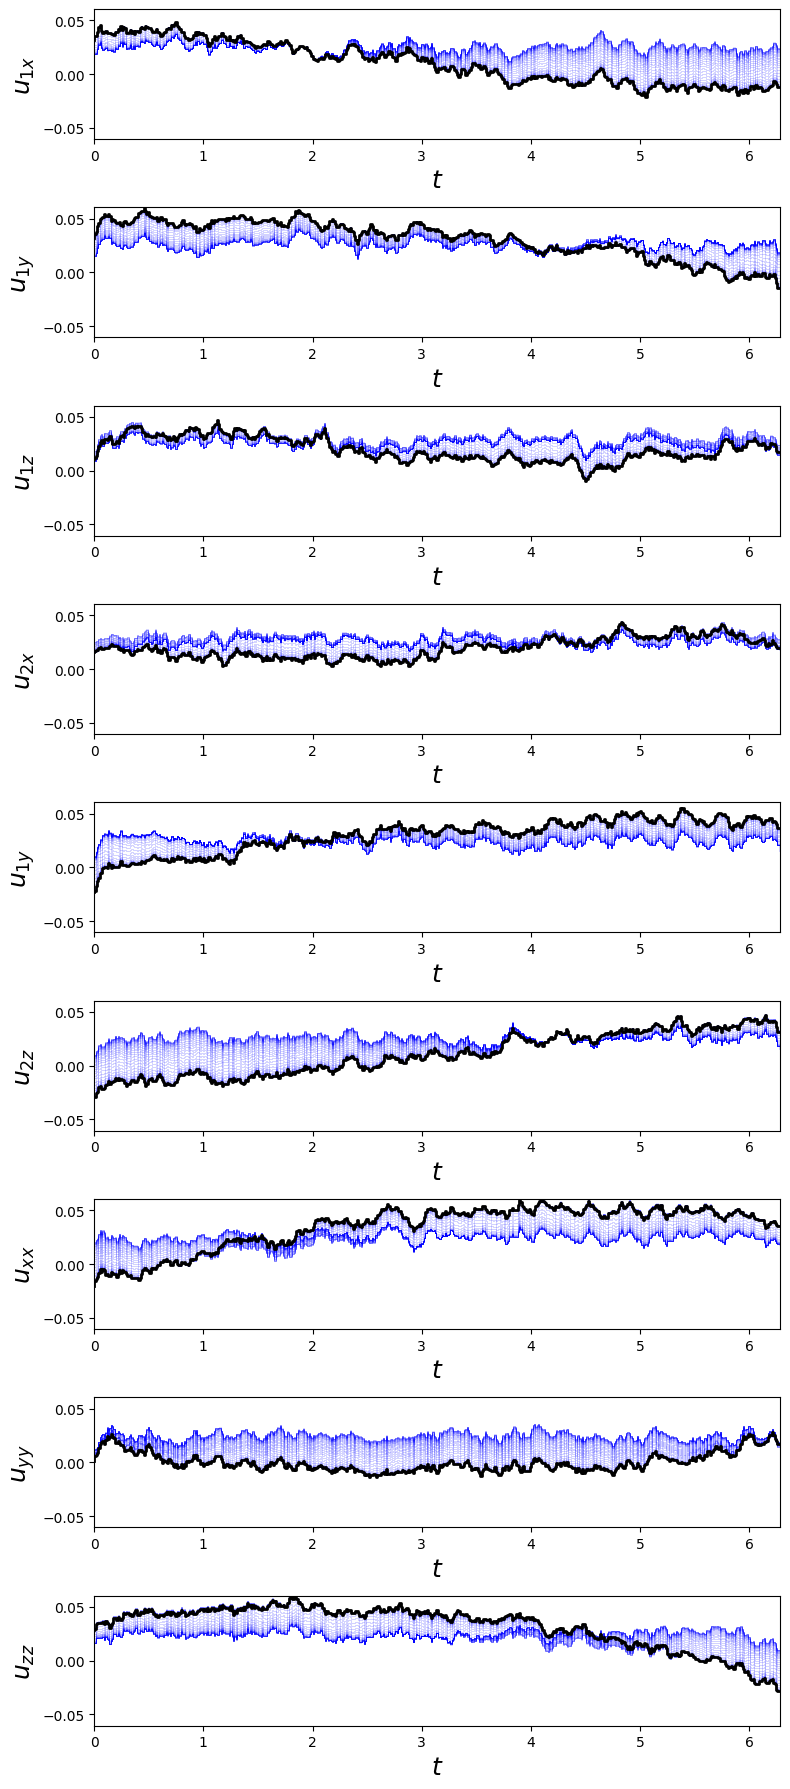

In [49]:
plot_grape_control_fields(times, result.u / (2 * np.pi), H_labels, uniform_axes=True);


Blue lines are iterated laser puse while optimizing. Black is the final pulse.

### Fidelity/Overlap

In [50]:
# Print Target Unitary
U

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [51]:
# Print Result Unitary
result.U_f

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-7.07106781e-01+7.07106781e-01j  8.91214186e-16-1.12475133e-15j
   6.15826834e-16-1.05189295e-15j  3.17345976e-16+1.13808702e-15j]
 [ 1.65232411e-15-1.36956418e-15j -7.07106781e-01+7.07106781e-01j
   8.03393810e-16+5.25838054e-17j  5.93709110e-16-2.38264269e-15j]
 [-1.66576822e-15-4.30211422e-16j  1.07682960e-15-3.92047506e-16j
  -1.32272665e-17-4.53196508e-16j -7.07106781e-01+7.07106781e-01j]
 [ 3.46944695e-17+2.39174999e-16j  2.37115015e-16-8.19656842e-16j
  -7.07106781e-01+7.07106781e-01j  2.46547574e-16+1.89952221e-16j]]

In [52]:
# Standardize the result
result.U_f/result.U_f[0,0]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.00000000e+00 -1.42550289e-15 -1.17925597e-15  5.80351558e-16]
 [-2.13679771e-15  1.00000000e+00 -5.30902846e-16 -2.10459854e-15]
 [ 8.73670589e-16 -1.03865296e-15 -3.11105234e-16  1.00000000e+00]
 [ 1.44589569e-16 -7.47250547e-16  1.00000000e+00 -4.00189582e-17]]

In [53]:
# Caluculate the fidelity and overlap
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f))**2

(-0.7071067811865478, 1.0000000000000009)

Its almost same with the target unitary.
### Test numerical integration of GRAPE pulse

In [54]:
# Conver the Hamiltonian(Qobj) to QobjEvo
H_t_evo = QobjEvo(result.H_t, tlist=times)

In [55]:
# Check the Hamiltonian
H_t_evo

QobjEvo: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, superrep = None, isconstant = False, num_elements = 10

In [56]:
U_f_num = propagator(H_t_evo, times[-1], [], options=Options(nsteps=5000), args={})
U_f_num

C:\Users\Issei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-7.06893079e-01+7.07315195e-01j  1.73858659e-03-1.50975070e-03j
  -1.19328899e-03+5.49180989e-04j -1.74903669e-04+6.48400259e-04j]
 [-1.50823077e-03+1.73770862e-03j -7.06943708e-01+7.07264217e-01j
  -1.95051432e-04+6.39967661e-04j -2.84437838e-04+1.46153903e-03j]
 [ 6.51228827e-04-1.75382644e-04j  1.45964565e-03-2.84256295e-04j
   4.85629403e-04-2.56610413e-04j -7.07233350e-01+7.06978156e-01j]
 [ 5.51049710e-04-1.19392941e-03j  6.39202753e-04-1.92656556e-04j
  -7.07349648e-01+7.06862218e-01j -2.56254144e-04+4.83848410e-04j]]

In [57]:
U_f_num / U_f_num[0,0]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j -2.29688141e-03-1.62497590e-04j
   1.23198089e-03+4.55822563e-04j  5.82265852e-04-3.34640106e-04j]
 [ 2.29528257e-03-1.61580851e-04j  9.99999732e-01+7.18473057e-05j
   5.90543722e-04-3.14428192e-04j  1.23484503e-03-8.31970767e-04j]
 [-5.84404278e-04-3.36649755e-04j -1.23288131e-03-8.31496881e-04j
  -5.24796386e-04-1.62098129e-04j  1.00000214e+00+4.78932886e-04j]
 [-1.23402676e-03+4.54217963e-04j -5.88121258e-04-3.15932569e-04j
   1.00000235e+00+6.43148917e-04j  5.23381481e-04-1.60777831e-04j]]

In [58]:
_overlap(result.U_f, U_f_num).real, abs(_overlap(result.U_f, U_f_num))**2

(0.9999974053809566, 0.9999948107686453)

In [59]:
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", 'z']] * 2

fig = plt.figure(figsize=(12,8))

U = cnot()

U_i_s = to_super(U)

chi = qpt(U_i_s, op_basis)

fig = qpt_plot_combined(chi, op_label, op_label, fig=fig, threshold=0.001)

plt.show()

TypeError: _remove_margins.<locals>._get_coord_info_new() missing 1 required positional argument: 'renderer'

<Figure size 1200x800 with 2 Axes>

In [60]:
fig = plt.figure(figsize=(12,6))

U_f_s = to_super(result.U_f)

chi = qpt(U_f_s, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)


Error in callback <function _draw_all_if_interactive at 0x00000180BE839F80> (for post_execute), with arguments args (),kwargs {}:


TypeError: _remove_margins.<locals>._get_coord_info_new() missing 1 required positional argument: 'renderer'

TypeError: _remove_margins.<locals>._get_coord_info_new() missing 1 required positional argument: 'renderer'

<Figure size 1200x600 with 2 Axes>

In [61]:
from qutip.ipynbtools import version_table

version_table()